In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9,5)
import math
import csv
import numpy as np

## Read in the data

In [2]:
with open('sim_fast_s_turn.csv') as fin:
    csvin = csv.reader(fin)
    column_names = next(csvin)
    data_rows = []
    for r in csvin:
        data_rows.append([float(x) for x in r])

## Compute position from encoders
We are going to need the position for the Kalman filter measurement. Obviously, this is not how we would run for real, but let's 
get a working filter.

In [3]:
class Encoder2Position(object):
    def __init__(self, wheel_base):
        self.wheel_base = wheel_base
        self.reset()
        return
    
    def reset(self):
        self.curr_pos = [0.0, 0.0, 0.0]
        self.prev_enc = [0.0, 0.0]
        return
    
    def compute(self, l_enc, r_enc):
        l = l_enc - self.prev_enc[0]
        r = r_enc - self.prev_enc[1]

        #print(l, r)
        # robot sim is backwards!! For now, make this agree
        d_theta = (l - r) / self.wheel_base
        d_avg = (l + r) / 2.0
        #print(d_theta, d_avg)
        if abs(d_theta) < 1e-4:
            dx = d_avg
            dy = 0
        else:
            r_c = d_avg / d_theta
            dx = r_c * math.sin(d_theta)
            dy = r_c * (1.0 - math.cos(d_theta))

        self.curr_pos[2] += d_theta
        c = math.cos(self.curr_pos[2])
        s = math.sin(self.curr_pos[2])
            
        self.curr_pos[0] += dx*c - dy*s
        self.curr_pos[1] += dx*s + dy*c
        
        self.prev_enc[0] = l_enc
        self.prev_enc[1] = r_enc
        return self.curr_pos

In [4]:
enc2pos = Encoder2Position(22.0/12.0)
ind_l = column_names.index('EncoderLeft')
ind_r = column_names.index('EncoderRight')
pos_est = [(0, 0, 0, 0)]
for r in data_rows[1:]:
    pos = enc2pos.compute(r[ind_l], r[ind_r])
    pos_est.append((r[0], pos[0], pos[1], pos[2]))

Compare to real

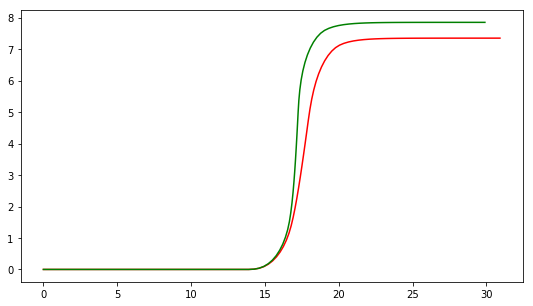

In [5]:
plt.rcParams['figure.figsize'] = (9,5)

x_est = [r[1] for r in pos_est]
y_est = [r[2] for r in pos_est]
plt.plot(x_est, y_est, color='red')

x_real = [r[1] for r in data_rows]
y_real = [r[2] for r in data_rows]
plt.plot(x_real, y_real, color='green');

The position calculated from just the encoders is not that great. Later, you will see that is it the uncertainty (or maybe just plain error) in the yaw angle. For now, let's just continue on.

## Some constants for the Kalman

In [6]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn

std_x, std_y, std_a = 3/12, 3/12, math.radians(2.0)
dt = 0.05

np.random.seed(1234)

## Regular linear Kalman filter (2 variable)
This won't be optimal, but let's see what it looks like

State variables are x, vx, y, vy

Measurements should be wheel encoder values. However, that requires non-linear calcs. *Cheat* and use the precalculated x, y from the encoder. 

We will create a routine so we can run with a few different parameters.

In [7]:
# input readings for the filter, with some added Gaussian noise
zs2 = [np.array([r[1] + randn()*std_x, r[2] + randn()*std_y]) for r in pos_est]

In [8]:
def run_kalman(uncertainty_accel):
    kf = KalmanFilter(4, 2)   # 4 state variables, 2 measurements
    kf.x = np.array(4*[0.,])  # starting state

    # simple linear F matrix. Position changes due to velocity
    kf.F = np.array([[1, dt, 0,  0 ], 
                     [0,  1, 0,  0],
                     [0,  0, 1, dt],
                     [0,  0, 0,  1],])

    # measurement uncertainy matrix
    kf.R = np.diag([std_x**2, std_y**2])

    # measurement matrix: measurements are just (x, y)
    kf.H = np.array([[1, 0, 0, 0],
                     [0, 0, 1, 0]
                     ])

    # state propagation noise
    kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=uncertainty_accel**2)
    kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=uncertainty_accel**2)
             
    # We could use the "batch_filter" method, but let's use what we would in real life
    xs2 = [np.copy(kf.x),]
    for r in zs2[1:]:
        kf.predict()
        kf.update(r)
        xs2.append(np.copy(kf.x))
    return xs2

Set the state prediction uncertainty. This is controlled by the uncertainty on the acceleration. Try 2 ft/sec/sec, which is a bit low.

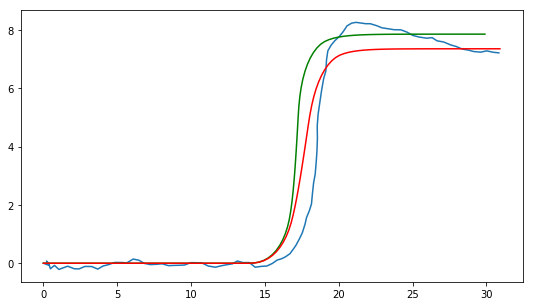

In [9]:
xs2 = run_kalman(2.0)
plt.plot([r[0] for r in xs2], [rr[2] for rr in xs2])

x_real = [r[1] for r in data_rows]
y_real = [r[2] for r in data_rows]
plt.plot(x_real, y_real, color='green')

x_est = [r[1] for r in pos_est]
y_est = [r[2] for r in pos_est]
plt.plot(x_est, y_est, color='red');

Not so good. It really lags behind on the turns. That is because it does not want to crank up the acceleration, so the velocity can only change slowly.

What about a more realistic number? The rule of thumb is use about 1/2 of the actual maximum value, so maybe 4 ft/sec/sec?

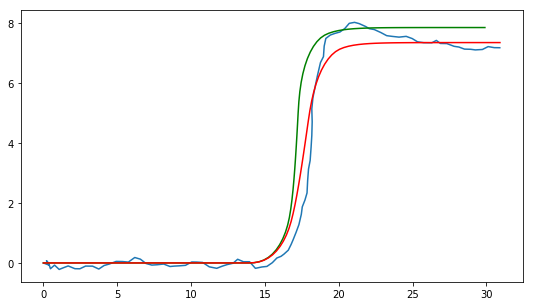

In [10]:
xs2 = run_kalman(4.0)
plt.plot([r[0] for r in xs2], [rr[2] for rr in xs2])

x_real = [r[1] for r in data_rows]
y_real = [r[2] for r in data_rows]
plt.plot(x_real, y_real, color='green')

x_est = [r[1] for r in pos_est]
y_est = [r[2] for r in pos_est]
plt.plot(x_est, y_est, color='red');

Well, not too bad. But notice it is getting really jaggy. It is following the noise too closely, instead of smoothing it out.

But, probably time to move to a better filter.

## Regular linear Kalman filter (3 variable)

Variables are x, vx, y, vy, angle, vangle

Again, cheat and use the precalculated position and angle.

In [11]:
zs3 = [np.array([r[1] + randn()*std_x, r[2] + randn()*std_y, r[3] + randn()*std_a]) for r in pos_est]

In [12]:
def run_kalman(uncertainty_accel, uncertainty_angle_accel):
    kf = KalmanFilter(6, 3)
    kf.x = np.array(6*[0.,])
    kf.F = np.array([[1, dt, 0,  0, 0,  0], 
                     [0,  1, 0,  0, 0,  0],
                     [0,  0, 1, dt, 0,  0],
                     [0,  0, 0,  1, 0,  0],
                     [0,  0, 0,  0, 1, dt],
                     [0,  0, 0,  0, 0,  1]])

    kf.R = np.diag([std_x**2, std_y**2, std_a**2])
    kf.H = np.array([[1, 0, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0],
                     ])
 
    kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=uncertainty_accel**2)
    kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=uncertainty_accel**2)
    kf.Q[4:6, 4:6] = Q_discrete_white_noise(2, dt=dt, var=uncertainty_angle_accel**2)
             
    # We could use the "batch_filter" method, but let's use what we would in real life
    xs3 = [np.copy(kf.x),]
    for r in zs3[1:]:
        kf.predict()
        kf.update(r)
        xs3.append(np.copy(kf.x))
    return xs3

Let's try 2 ft/sec/sec again. Angular acceleration, maybe 30 deg/sec/sec??

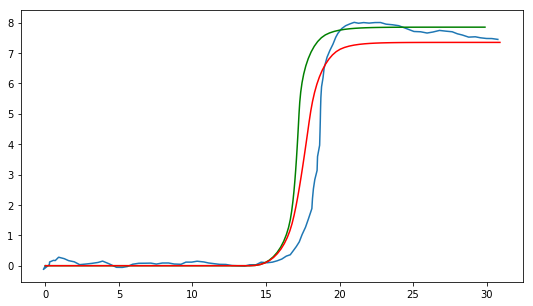

In [13]:
xs3 = run_kalman(2, math.radians(30))
plt.plot([r[0] for r in xs3], [rr[2] for rr in xs3])

x_real = [r[1] for r in data_rows]
y_real = [r[2] for r in data_rows]
plt.plot(x_real, y_real, color='green')

x_est = [r[1] for r in pos_est]
y_est = [r[2] for r in pos_est]
plt.plot(x_est, y_est, color='red');

Again same problem. Try 4 ft/sec/sec

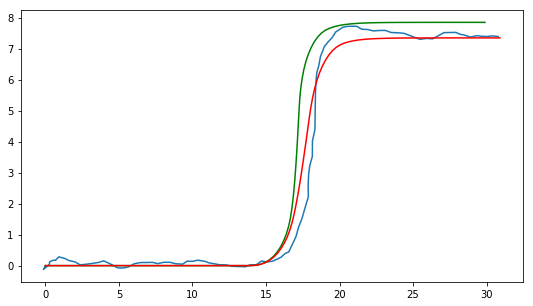

In [14]:
xs3 = run_kalman(4, math.radians(30))
plt.plot([r[0] for r in xs3], [rr[2] for rr in xs3])

x_real = [r[1] for r in data_rows]
y_real = [r[2] for r in data_rows]
plt.plot(x_real, y_real, color='green')

x_est = [r[1] for r in pos_est]
y_est = [r[2] for r in pos_est]
plt.plot(x_est, y_est, color='red');

Looks pretty similar. Adding the angle may not have helped?